# Accessing DESI DR1 with searchable catalog and spectra databases 
*Stéphanie Juneau (NOIRLab), Ragadeepika Pucha (U. Utah), Alice Jacques (NOIRLab), Benjamin Weaver (NOIRLab), Anthony Kremin (LBL), Stephen Bailey (LBL), Astro Data Lab Team, and DESI Data Team*

### Table of Contents

* [Goals](#goals)
* [Disclaimer & attribution](#attribution)
* [Imports](#import)
* [DESI DR1 database](#desi_edr)
* [Accessing DESI targets](#desi_target_access)
    * [Selecting sources based on targeting information](#target_info)
    * [Selecting sources in a region of the sky](#hpx_sel)
* [Accessing and plotting the spectra of a given object](#spectra_access)
* [Objects with multiple coadded spectra](#multiple_spectra)
* [Acknowledgments](#ack)

<a class="anchor" id="goals"></a>
# Goals

The DESI DR1 catalog and spectra files have significant size and complexity. The tutorial notebooks in this series demonstrate several tips and example cases.

This notebook showcases the use of **publicly accessible databases** to query the DESI catalogs and the full-depth ("HEALPix coadded") spectra. It uses the [Astro Data Lab](https://datalab.noirlab.edu/) to query database tables then uses SPectra Analysis and Retrievable Catalog Lab ([SPARCL](https://astrosparcl.datalab.noirlab.edu/)) to retrieve the spectra.

### If necessary, install the datalab and sparcl clients

If you are using the Astro Data Lab Jupyter notebook server, you do not need to run these cell because they are already installed.

#### NOTE: After installing the most recent version, please restart your kernel.

In [1]:
## Uncomment the following only if the Astro Data Lab client is not already installed
#!pip install --upgrade astro-datalab

In [2]:
## Uncomment the following only if SPARCL client is not already installed
#!pip install --upgrade sparclclient

### Disclaimers & Attribution
Note that using the Astro Data Lab constitutes your agreement with the following minimal [Disclaimers](https://datalab.noirlab.edu/disclaimers.php).

If you use or modify this notebook for your work, make sure to include acknowledgments for:
- DESI data license and acknowledgments: https://data.desi.lbl.gov/doc/acknowledgments/
- Astro Data Lab: https://datalab.noirlab.edu/acknowledgments.php
- SPARCL: https://astrosparcl.datalab.noirlab.edu/sparc/acknowledgments/

<a class="anchor" id="import"></a>
# Imports

In [3]:
# import some helpful python packages 
import numpy as np
from astropy.convolution import convolve, Gaussian1DKernel
import matplotlib.pyplot as plt
import pandas as pd

## DataLab and SPARCL related modules
from sparcl.client import SparclClient
from dl import queryClient as qc

# plots default setup
plt.rcParams['font.size'] = 14
# Axes width
width = {'linewidth':1.5}
plt.rc('axes', **width)
# x- and y- ticks
ticks = {'major.size':5.0, 'minor.size':3.0, 'major.width':1.5, 'minor.width':1., 'direction':'in',\
        'minor.visible':True}
plt.rc('xtick', **ticks)
plt.rc('ytick', **ticks)

In [4]:
## Instantiate SPARCLClient
client = SparclClient()

<a class="anchor" id="desi_dr1"></a>
# DESI DR1 database

The `desi_dr1` database schema at Data Lab consists of several tables associated with the targets.

In [5]:
print(qc.schema('desi_dr1'))


Schema: desi_dr1

      Table Name   Description
      ----------   -----------
        exposure   Summary quantities for every DESI exposure
     fiberassign   Quantities obtained when a DESI target is assigned to a fiber
           frame   Summary quantities for each petal of the DESI instrument i
                   n a given exposure; in normal operation there are ten fram
                   es for every exposure
      photometry   Photometric quantities from LS DR9 for every TARGETID
       potential   For a given tile, this table lists all targets that could 
                   have received a fiber assignment
          target   The quantities obtained when photometric objects are analy
                   zed in the target selection process
            tile   Summary quantities for every DESI tile (pointing on the sky)
x1p5__zpix__allwise__source   desi_dr1.zpix and xmatch_std.allwise__source crossmatch (1
                   .5 arcsec)
x1p5__zpix__gaia_dr3__gaia_source   desi_dr1

We will focus on the `zpix` table in this notebook. This is the main redshift catalog from the DESI survey. It contains the redshift information from the coadded-spectra, based on the healpix of the objects. It also contains the targeting information of the different sources.

We look at the available columns in this table below.

In [6]:
## Columns in the zpix table
print(qc.schema('desi_dr1.zpix'))


Schema: desi_dr1
 Table: zpix

     Column Name   Description
     -----------   -----------
     tsnr2_bgs_z   BGS Z template (S/N)^2
tsnr2_gpbbackup_z   GPBBACKUP Z template (S/N)^2
     tsnr2_qso_z   QSO Z template (S/N)^2
               z   Redshift measured by Redrock
            zerr   Redshift error from Redrock
            chi2   Best fit chi squared
         coeff_0   Redrock template coefficients
         coeff_1   Redrock template coefficients
         coeff_2   Redrock template coefficients
         coeff_3   Redrock template coefficients
         coeff_4   Redrock template coefficients
         coeff_5   Redrock template coefficients
         coeff_6   Redrock template coefficients
         coeff_7   Redrock template coefficients
         coeff_8   Redrock template coefficients
         coeff_9   Redrock template coefficients
       deltachi2   Delta-chi-squared for template fit from Redrock
   mean_fiber_ra   Mean (over exposures) RA of actual fiber position
  mean_fiber

<a class="anchor" id="desi_target_access"></a>
# Accessing DESI targets

The DESI spectra are uniquely identified by three quantities:

* **targetid**: unique identifier for a given target
* **survey**: SURVEY that the target was observed in. This can be _cmx_, _special_, _sv1_, _sv2_, or _sv3_.
* **program**: FIBER ASSIGNMENT PROGRAM. This is the planned observing conditions for the target. It can be _dark_ or _bright_ or _backup_. In case of _cmx_ and _sv1_, there is _other_ as well.
    
The different spectra of individual targets are coadded within each survey and program. Therefore, some targets may have multiple coadded spectra and each one is associated with a given `targetid`, `survey`, and `program`. The "best" spectrum for a given object is given by the `zcat_primary` column. More information about the data model of the redshift catalogs is available [here](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/zcatalog/zpix-SURVEY-PROGRAM.html#).

For this query, we will select from the Main survey (`survey='main'`). Because the zpix table is large with 23 million rows, we will only get 10% randomly distributed on the sky, by making a cut on `random_id` (Random ID in the range 0.0 => 100.0).

In [7]:
# Write a query to select the primary spectrum in the Main survey for 10% of the sample
# (see detailed information below)
query = """
        SELECT zp.targetid, zp.survey, zp.program, zp.desi_target, 
               zp.mean_fiber_ra, zp.mean_fiber_dec, 
               zp.z, zp.zwarn, zp.spectype
        FROM desi_dr1.zpix AS zp
        WHERE (zp.survey='main') AND zp.main_primary AND (zp.random_id BETWEEN 0. AND 10.)
        """ 

## Information about the query
## 
## Selected columns --
##   targetid, survey, program -- unique identifiers for a given spectrum
##   desi_target -- encodes main survey's desi targeting information - explained in detail below
##   mean_fiber_ra, mean_fiber_dec -- coordinates where fiber was placed
##   z -- spectroscopic redshift of the target
##   zwarn -- encoded information regarding the redshift (zwarn = 0 is good)
##   spectype -- Spectral type of the target: STAR | GALAXY | QSO
## Constraints (WHERE statement) --
##   survey: selecting main survey only
##   main_primary: keeping only the best spectrum in Main (removes possible multiples)
##   random_id: selects a slice of 10% of the sample (0-10 out of 100)

In [8]:
## This query can take up to 1min with 10% of DR1 sample
zpix_cat = qc.query(sql = query, fmt = 'table')

In [9]:
print(f"The resulting table has {len(zpix_cat)} rows, and comprises 10% of the sample size")
zpix_cat[0:5]

The resulting table has 2063506 rows, and comprises 10% of the sample size


targetid,survey,program,desi_target,mean_fiber_ra,mean_fiber_dec,z,zwarn,spectype
int64,str4,str6,int64,float64,float64,float64,int64,str6
39628129664239940,main,dark,65537,234.7166322469532,14.27766943485698,0.6129316573380434,0,GALAXY
39627660451645263,main,dark,917542,146.505791478883,-5.361541128676229,2.274544489801376,0,QSO
39632981819656750,main,dark,1028,250.8452391416031,34.96682360092108,3.026060340852765,0,QSO
39628310233219875,main,dark,65537,36.75448828509968,22.26330131482691,0.5896048730671053,0,GALAXY
39627715627715582,main,dark,655394,201.3880181513268,-2.939781972005333,1.541882595749106,0,GALAXY


In [10]:
## Check that rows have unique TARGETIDs (only one PRIMARY spectrum per object)
Ntot = len(zpix_cat)
print(f"Total N(rows) : {Ntot}")
print(f"N(rows) with unique TARGETIDs : {len(np.unique(zpix_cat['targetid']))}")

Total N(rows) : 2063506
N(rows) with unique TARGETIDs : 2063506


In [11]:
## Check the spectral types
spectypes = np.unique(zpix_cat['spectype'])

for spectype in spectypes:
    Nspectype = len(zpix_cat[zpix_cat['spectype']==spectype])
    # Percentage rounded to 1 decimal
    percent = np.round(Nspectype/Ntot*100, 1)
    print(f"SPECTYPE={spectype} includes N={Nspectype} ({percent}%)")

SPECTYPE=GALAXY includes N=1479652 (71.7%)
SPECTYPE=QSO includes N=165098 (8.0%)
SPECTYPE=STAR includes N=418756 (20.3%)


<a class="anchor" id="target_info"></a>
## Selecting sources based on targeting information

DESI targets are divided into five main classes:
* MWS: Milky Way Survey - This survey probes "stars" in the Milky Way.
* BGS: Bright Galaxy Survey - This survey probes the bright galaxies in the nearby universe.
* LRG: Luminous Red Galaxies
* ELG: Emission Line Galaxies
* QSO: Quasars

[Myers et al. 2023](https://ui.adsabs.harvard.edu/abs/2023AJ....165...50M/abstract) describe the target selection and information in more detail. Apart from these main classes, there are also secondary fiber targets that are based on different secondary programs in DESI (SCND targets).

The `*DESI_TARGET` columns encode the information related to which class the target belongs to. Note that some sources can be part of different classes. 

In this section, we show how to select sources based on their targeting information.

The information about different target bits is available [here](https://desidatamodel.readthedocs.io/en/latest/bitmasks.html#target-masks). By using the target bits directly, we avoid the usage of targetmasks that come from DESI software.

In [12]:
## Function to check the bits

def check_bits(table, bit):
    """
    Function to check the bits corresponding to the main target classes.

    Parameters
    ----------
    table : astropy table
        Table of DESI targets with required sv*desi_target columns
        
    bit : int
        Target bit from DESI

    Returns
    -------
    res : numpy array
        Boolean array corresponding to the bit
    """
    # Targeting information about the DESI targeting is stored in the different desi_target columns
    desi_tgt = table['desi_target']

    # If notebook is modified to use the SV data, need to query the sv*_desi_target 
    # columns and uncomment the code below
#    sv1_desi_tgt = table['sv1_desi_target']
#    sv2_desi_tgt = table['sv2_desi_target']
#    sv3_desi_tgt = table['sv3_desi_target']
        
    val = (2**bit)

    # Apply the selection
    res = desi_tgt & val != 0

    # Version for SV and Main data below (if notebook is modified accordingly)
#    res = (desi_tgt & val != 0)|(sv1_desi_tgt & val != 0)|(sv2_desi_tgt & val != 0)|(sv3_desi_tgt & val != 0)

    return (res)

In [13]:
## Selecting candidates - 
## Target bits from DESI:
## 1. BGS: bit 60
## 2. LRG: bit 0
## 3. ELG: bit 1
## 4. QSO: bit 2
## 5. MWS: bit 61
## 6. Secondary Targets: bit 62

is_bgs = check_bits(zpix_cat, 60)
is_lrg = check_bits(zpix_cat, 0)
is_elg = check_bits(zpix_cat, 1)
is_qso = check_bits(zpix_cat, 2)
is_mws = check_bits(zpix_cat, 61)
is_scnd = check_bits(zpix_cat, 62)

In [14]:
# Number of sources of each target type
n_bgs = len(zpix_cat[is_bgs])
n_lrg = len(zpix_cat[is_lrg])
n_elg = len(zpix_cat[is_elg])
n_qso = len(zpix_cat[is_qso])
n_mws = len(zpix_cat[is_mws])
n_scnd = len(zpix_cat[is_scnd])

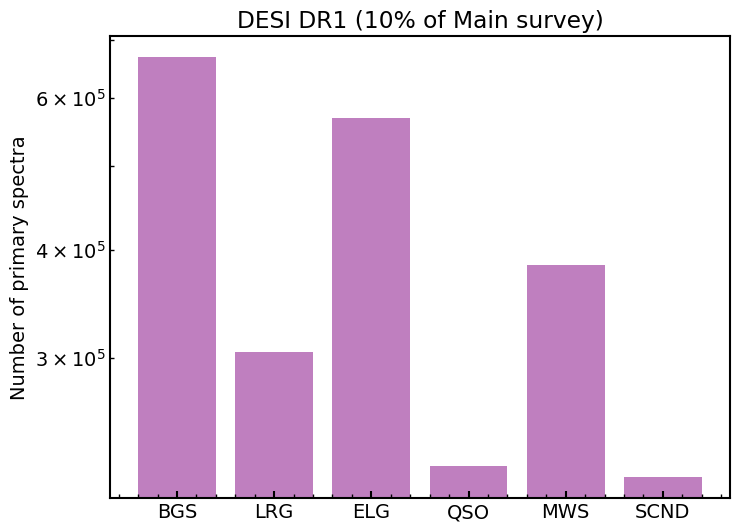

In [15]:
# Let us look at the numbers visually - 

plt.figure(figsize = (8,6))

targets = ['BGS', 'LRG', 'ELG', 'QSO', 'MWS', 'SCND']
numbers = [n_bgs, n_lrg, n_elg, n_qso, n_mws, n_scnd]

plt.bar(targets, numbers, color = 'purple', alpha = 0.5)
plt.ylabel('Number of primary spectra')
plt.yscale('log')
plt.title('DESI DR1 (10% of Main survey)');

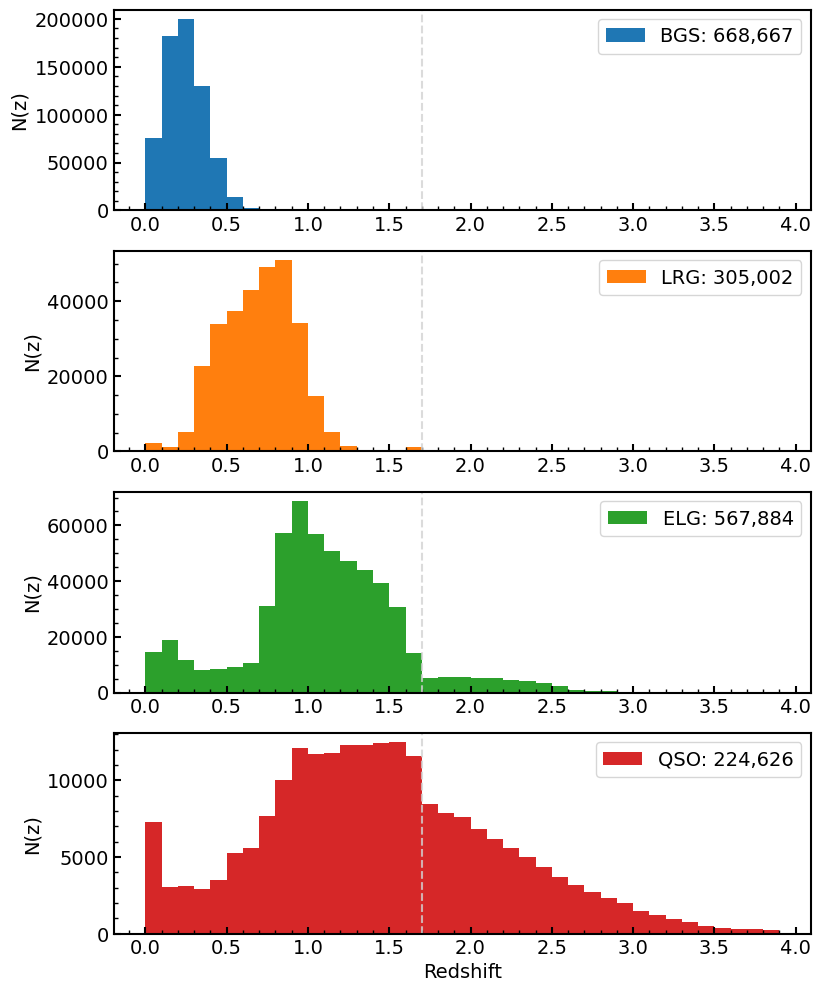

In [16]:
# Now let us look at the distribution of redshifts -

fig, axs = plt.subplots(4, 1, figsize = (9, 12))

# Define the redshift bins for the histograms
bins = np.arange(0, 4, 0.1)

# Will iterate over these 4 target classes
targets = [is_bgs, is_lrg, is_elg, is_qso]
colors = ['C0', 'C1', 'C2', 'C3']
labels = [f'BGS: {n_bgs:,}', f'LRG: {n_lrg:,}', f'ELG: {n_elg:,}', f'QSO: {n_qso:,}']

for i, target in enumerate(targets):
    axs[i].hist(zpix_cat['z'][target], color=colors[i], bins=bins, label=labels[i])
    axs[i].legend(fontsize=14)
    axs[i].set_ylabel("N(z)")

    # Vertical line at the limit for GALAXY spectype
    axs[i].axvline(1.7, ls='--', color='lightgrey', alpha=0.8)

# Add x-label on the last panel
axs[3].set_xlabel("Redshift");

### Other masks

The `DESI_TARGET` column consists of the uppermost level targeting information in DESI. However, there are sub-classes of targets. <br/>
For example, BGS have different target masks depending on the selection criterion. Each of the different secondary target proposals have their own masks. They can be selected in a similar way as above, but with the respective columns (like `BGS_TARGET` or `SCND_TARGET`. More information about Bitmasks in DESI is available [here](https://desidatamodel.readthedocs.io/en/latest/bitmasks.html).

<a class="anchor" id="hpx_sel"></a>
## Selecting sources in a region of the sky

Here, we show how to query unique targets from DESI DR1 in a given region of the sky. 

We also select and overplot the `Milky Way Survey` targets in this region.

In [17]:
hpx = 26279      

## Write query to select this given healpix (detailed information below)
query = f'''SELECT zp.targetid, zp.survey, zp.program, zp.desi_target,
                   zp.z, zp.zwarn, zp.spectype, 
                   zp.mean_fiber_ra, zp.mean_fiber_dec 
            FROM desi_dr1.zpix AS zp
            WHERE (healpix={hpx} AND survey='main' AND main_primary)'''

## Information about the query
## 
## Selected columns:
##   targetid, survey, program -- unique identifiers for a given spectrum
##   desi_target -- encodeds main survey's desi targeting information
##   z -- spectroscopic redshift of the target
##   zwarn -- encoded information regarding the redshift (zwarn = 0 is good)
##   spectype -- Spectral type of the target: STAR | GALAXY | QSO
##   mean_fiber_ra, mean_fiber_dec -- coordinates where fiber was placed
## Constraints (WHERE statement):
##   healpix: select a specific one
##   survey: keep only the Main survey
##   main_primary: keep the best spectrum in the Main survey (in case there are duplicates)

In [18]:
tsel = qc.query(sql = query, fmt = 'table')

In [19]:
## MWS bit - 61
is_mws = check_bits(tsel, 61)

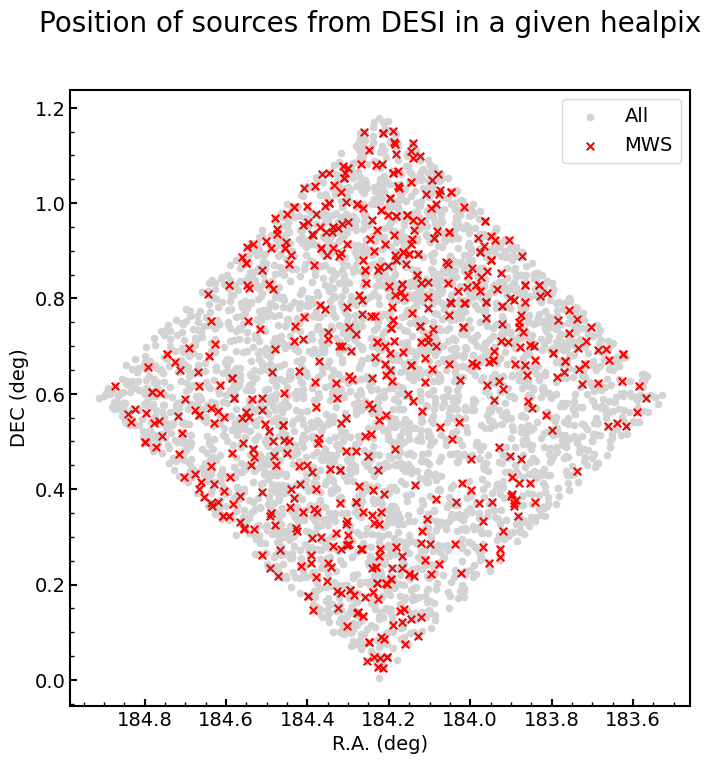

In [20]:
plt.figure(figsize = (8, 8))

plt.suptitle('Position of sources from DESI in a given healpix', fontsize = 20)
plt.scatter(tsel['mean_fiber_ra'], tsel['mean_fiber_dec'], color = 'lightgrey', s = 20, label = 'All')
plt.scatter(tsel['mean_fiber_ra'][is_mws], tsel['mean_fiber_dec'][is_mws], color = 'r', s = 30, marker = 'x', label = 'MWS')
plt.xlabel('R.A. (deg)')
plt.ylabel('DEC (deg)')
## RA increases toward the left (East)
plt.gca().invert_xaxis()
plt.legend();

<a class="anchor" id="spectra_access"></a>
# Accessing and plotting the spectra of a given object

Finally, we show how to access all the available healpix-coadded spectra of a given object. We also show how to select the "best" spectrum.  
We use SPARCL, which is a fast spectral access service at Data Lab.  
Detailed ways to using SPARCL are available in this [tutorial notebook](https://github.com/astro-datalab/notebooks-latest/blob/master/04_HowTos/SPARCL/How_to_use_SPARCL.ipynb).

In [21]:
## Select objects with nspec > 5
query = '''SELECT targetid, survey, program, z, zwarn, coadd_fiberstatus, 
                  zcat_primary, zcat_nspec, tsnr2_lrg
           FROM desi_dr1.zpix
           WHERE zcat_nspec>5
        '''

tsel = qc.query(sql=query, fmt='table')

In [22]:
len(tsel)

782

In [23]:
## Randomly select an object
## You can test any object with ii = 0 to 307

ii = 50
targetid = int(tsel['targetid'].data[ii])   ## SPARCL accepts only python integers

## Save a table with the rows that share the same targetid as selected
tsel_id = tsel[tsel['targetid']==tsel['targetid'][ii]]

In [24]:
## Retrieve Spectra

inc = ['specid', 'redshift', 'flux', 'wavelength', 'spectype', 'specprimary', 'survey', 'program', 'targetid', 'redshift_warning']
res = client.retrieve_by_specid(specid_list = [targetid],
                                include = inc,
                                dataset_list = ['DESI-DR1'])

In [25]:
## Checking that all the different spectra are retrieved

print ('Number of coadded spectra: ', tsel['zcat_nspec'].data[ii])
print ('Number of retrieved records: ', len(res.records))

Number of coadded spectra:  6
Number of retrieved records:  6


In [26]:
records = res.records

## Select the primary spectrum
spec_primary = np.array([records[jj].specprimary for jj in range(len(records))])

primary_ii = np.where(spec_primary == True)[0][0]

In [27]:
lam_primary = records[primary_ii].wavelength
flam_primary = records[primary_ii].flux

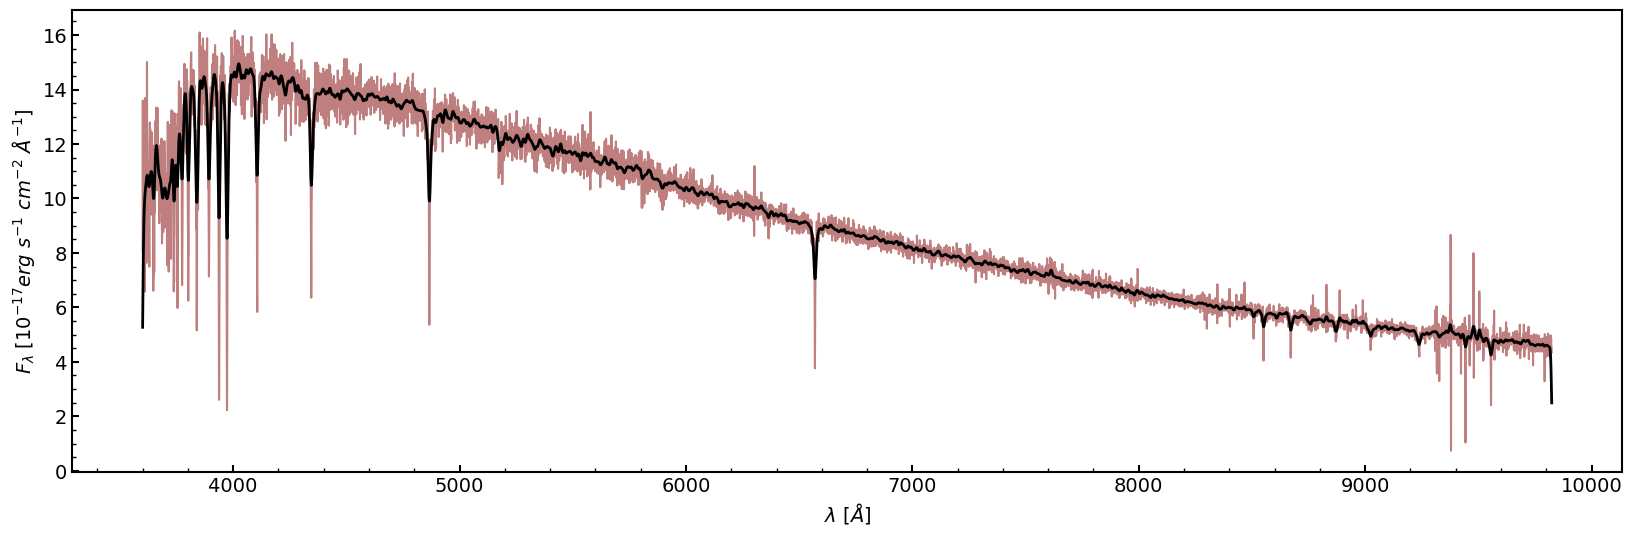

In [28]:
## Plotting this spectrum -

plt.figure(figsize = (20, 6))

# Plot the original spectrum in maroon color
plt.plot(lam_primary, flam_primary, color = 'maroon', alpha = 0.5)
# Over-plotting smoothed spectrum in black 
plt.plot(lam_primary, convolve(flam_primary, Gaussian1DKernel(5)), color = 'k', lw = 2.0)
plt.xlabel(r'$\lambda$ [$\AA$]')
plt.ylabel(r'$F_{\lambda}$ [$10^{-17} erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')
plt.show()

Let us now plot all the available spectra for this object. 

In each case, the `survey`, `program`, `primary` flag and `zwarn` flag are labeled on the panel with the associated spectrum.

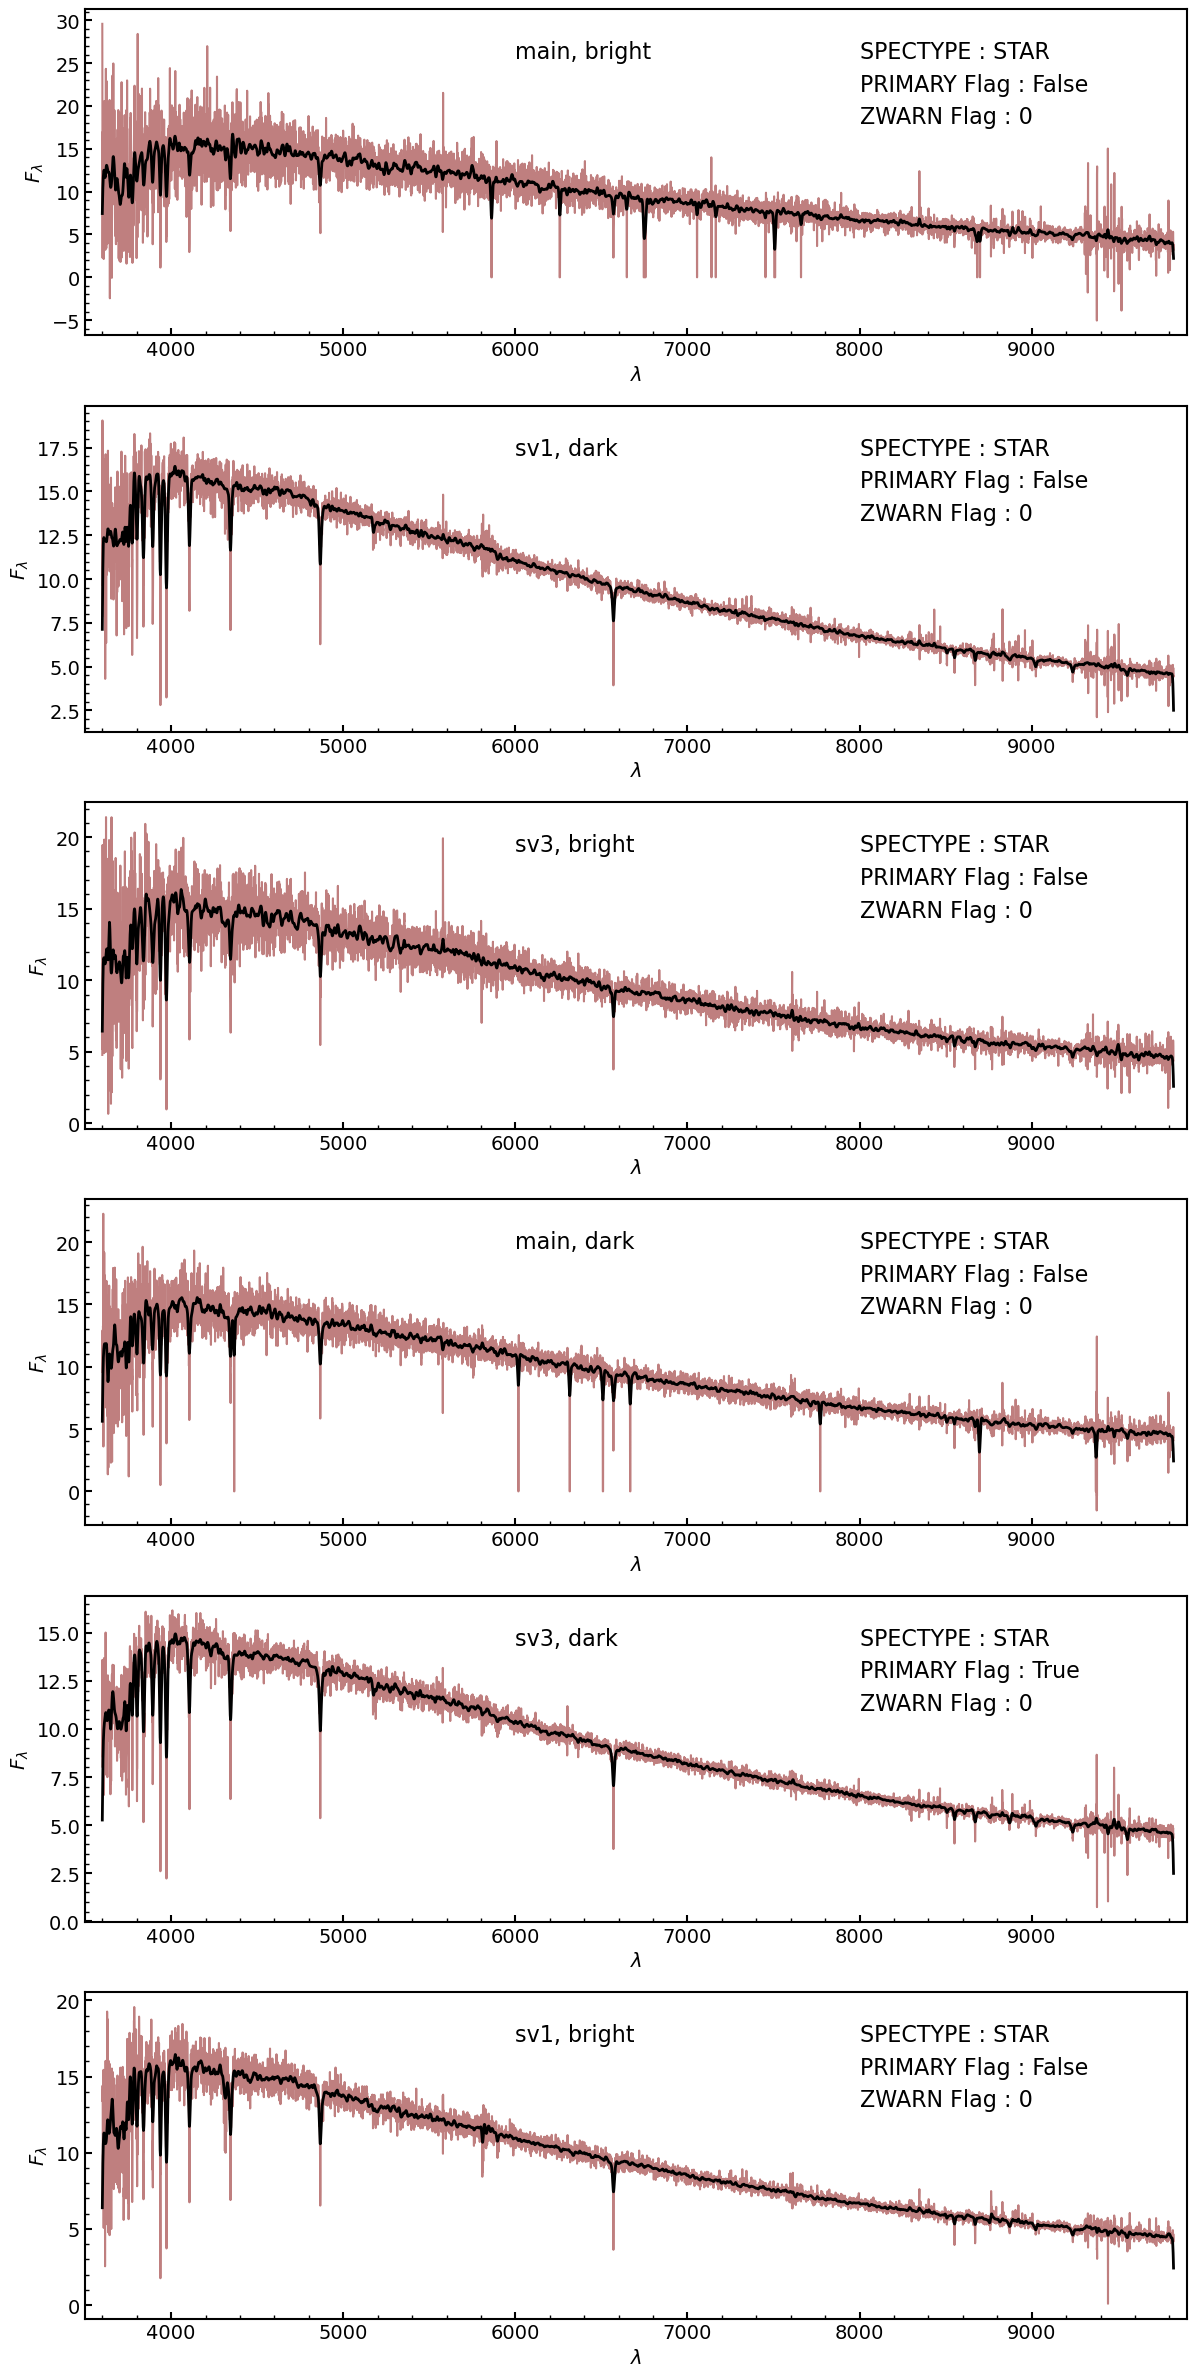

In [29]:
# Number of spectra 
n = len(records)

fig, ax = plt.subplots(n, 1, figsize = (12,(4*n)))

for jj in range(n):
    survey = records[jj].survey
    program = records[jj].program
    spectype = records[jj].spectype
    primary_flag = records[jj].specprimary
    zwarn_flag = records[jj].redshift_warning

    lam = records[jj].wavelength
    flam = records[jj].flux
    
    # Plot the combined spectrum in maroon
    ax[jj].plot(lam, flam, color = 'maroon', alpha = 0.5)
    # Over-plotting smoothed spectra 
    ax[jj].plot(lam, convolve(flam, Gaussian1DKernel(5)), color = 'k', lw = 2.0)
    ax[jj].set(xlim = [3500, 9900], xlabel = r'$\lambda$', ylabel = r'$F_{\lambda}$')
    trans = ax[jj].get_xaxis_transform()
    ax[jj].annotate(f'{survey}, {program}', xy = (6000, 0.85), xycoords = trans, fontsize = 16)
    ax[jj].annotate(f'SPECTYPE : {spectype}', xy = (8000, 0.85), xycoords = trans, fontsize = 16)
    ax[jj].annotate(f'PRIMARY Flag : {primary_flag}', xy = (8000, 0.75), xycoords = trans, fontsize = 16)
    ax[jj].annotate(f'ZWARN Flag : {zwarn_flag}', xy = (8000, 0.65), xycoords = trans, fontsize = 16)
    
plt.tight_layout()

From the above plot, we can see that the spectrum with PRIMARY Flag = True is the one with the highest signal-to-noise ratio. The other available spectra tend to vary in quality including some of them being noisier compared to the "best" spectrum.
Let's print the table of values of their quality flags including ZWARN and COADD_FIBERSTATUS to see if any have flagged issues. **Note**: in some cases if no valid data are available, the spectrum is blank with `ZWARN>0`.

In [30]:
tsel_id['targetid','survey','program','zwarn','coadd_fiberstatus','tsnr2_lrg','zcat_primary']

targetid,survey,program,zwarn,coadd_fiberstatus,tsnr2_lrg,zcat_primary
int64,str7,str6,int64,int64,float64,str1
39627751560317946,sv3,dark,0,0,358.0292,t
39627751560317946,main,bright,0,0,14.342091,f
39627751560317946,sv3,bright,0,0,47.464897,f
39627751560317946,sv1,bright,0,0,173.92639,f
39627751560317946,sv1,dark,0,0,329.90457,f
39627751560317946,main,dark,0,0,84.216095,f


**Notes:**
- `zwarn` contains possible redshift fitting warning or errors ([list of bit definitions](https://desidatamodel.readthedocs.io/en/latest/bitmasks.html#zwarn-bit-definitions)).
- `coadd_fiberstatus` contains [information about the fiber conditions](https://desidatamodel.readthedocs.io/en/latest/bitmasks.html#spectroscopic-reduction-masks) during the observations.
- When all spectra have `zwarn=0`, the best one is chosen by the value of `tsnr2_lrg`, which is a proxy for the achieved depth (signal-to-noise) of the spectrum.

If you got back to examine the spectra above, you might be able to see that the best looking ones (with less noise) have higher values of `tsnr2_lrg`. For instance, dark-time spectra achieve higher signal than bright-time ones.

<a class="anchor" id="multiple_spectra"></a>
## Objects with multiple coadded spectra

In [31]:
## Write a query to select all main objects with N>1 spectrum (detailed info below)
q_multi = """
        SELECT targetid, survey, program, desi_target, 
               z, zwarn, coadd_fiberstatus, spectype, 
               CAST(main_primary AS int), main_nspec
        FROM desi_dr1.zpix
        WHERE (survey='main') AND (main_nspec>1)
        """

## Information about the query
## 
## Selected columns --
##   targetid, survey, program -- unique identifiers for a given spectrum
##   desi_target -- encodes main survey's desi targeting information - explained in detail below
##   z -- spectroscopic redshift of the target
##   zwarn -- encoded information regarding the redshift (zwarn = 0 is good)
##   coadd_fiberstatus -- encoded information regarding the fiber that is assigned to the target (coadd_fiberstatus = 0 is good)
##   spectype -- Spectral type of the target: STAR | GALAXY | QSO
##   main_nspec -- Number of coadded spectra that are available for a given target
##   main_primary -- Whether or not a given coadded spectra is the primary spectra. ZCAT_PRIMARY = True for the "best" spectrum.
##   CASTing this column as an INT: ZCAT_PRIMARY = 1 for the "best" spectrum.
## Constraints (WHERE statement) --
##   survey: selecting main survey only
##   main_nspec: keeping objects with more than one Main survey spectrum
##               (e.g., they were observed on both DARK and BRIGHT programs)

In [32]:
zmulti = qc.query(sql = q_multi, fmt = 'table')

In [33]:
print(f"The resulting table has {len(zmulti)} rows")
zmulti[0:5]

The resulting table has 508470 rows


targetid,survey,program,desi_target,z,zwarn,coadd_fiberstatus,spectype,main_primary,main_nspec
int64,str4,str6,int64,float64,int64,int64,str6,int64,int64
39633221406692395,main,bright,2305843009213694980,0.9276516309963582,0,0,QSO,0,2
39633221406692395,main,dark,2305843009213694980,0.9276960025538751,0,0,QSO,1,2
39633225433219765,main,bright,1152921504606847233,0.3977524124527504,0,0,GALAXY,0,2
39633225433219765,main,dark,1152921504606847233,0.3979740015739428,0,0,GALAXY,1,2
39633217363383452,main,bright,2305843017803628544,-0.0006240696655950223,0,0,STAR,0,2


In [34]:
is_primary = zmulti['main_primary']==1

print(f"N(rows) with MAIN_PRIMARY=True : {len(zmulti[is_primary])}")
print(f"N(rows) with MAIN_PRIMARY=False: {len(zmulti[~is_primary])}")

N(rows) with MAIN_PRIMARY=True : 254235
N(rows) with MAIN_PRIMARY=False: 254235


In [35]:
## Check how many per program (and fraction that are "Primary" = "Best" spectrum)
programs = np.unique(zmulti['program'])
programs

for program in programs:
    is_prog = zmulti['program']==program
    is_mult = zmulti['main_nspec']>1
    N_prog = len(zmulti[is_prog])
    N_multiple = len(zmulti[is_prog&is_mult])
    N_primary = len(zmulti[is_prog&is_mult&is_primary])
    percent = np.round(N_primary/N_multiple*100, 1)

    print(f"Program={program}")
    print(f"  {N_multiple} have >1 spectrum; {N_primary} ({percent}%) are the primary")

Program=bright
  254235 have >1 spectrum; 3826 (1.5%) are the primary
Program=dark
  254235 have >1 spectrum; 250409 (98.5%) are the primary


**Note**: As expected, the dark-time spectra tend to have a higher quality than the bright-time ones so they are typically favored as the "best" primary spectrum.

**Exercise**: One could dig deeper to figure out why, in a small fraction of cases, the bright-time spectrum was chosen as the primary one. Is there something wrong with the fiber condition (`COADD_FIBERSTATUS>0`) and/or with the redshift determination (`ZWARN>0`) for the dark-time spectra in such cases?

<a class="anchor" id="ack"></a>
Acknowledgments
---------------

If you use any **DESI data**, refer to the official [DESI Acknowledgments and Data Licence page](https://data.desi.lbl.gov/doc/acknowledgments/).

If you use **Astro Data Lab** in your published research, please include the text in your paper's Acknowledgments section:

_This research uses services or data provided by the Astro Data Lab, which is part of the Community Science and Data Center (CSDC) Program of NSF NOIRLab. NOIRLab is operated by the Association of Universities for Research in Astronomy (AURA), Inc. under a cooperative agreement with the U.S. National Science Foundation._

If you use **SPARCL jointly with the Astro Data Lab platform** (via JupyterLab, command-line, or web interface) in your published research, please include this text below in your paper's Acknowledgments section:

_This research uses services or data provided by the SPectra Analysis and Retrievable Catalog Lab (SPARCL) and the Astro Data Lab, which are both part of the Community Science and Data Center (CSDC) Program of NSF NOIRLab. NOIRLab is operated by the Association of Universities for Research in Astronomy (AURA), Inc. under a cooperative agreement with the U.S. National Science Foundation._

In either case **please cite the following papers**:

* Data Lab concept paper: Fitzpatrick et al., "The NOAO Data Laboratory: a conceptual overview", SPIE, 9149, 2014, https://doi.org/10.1117/12.2057445

* Astro Data Lab overview: Nikutta et al., "Data Lab - A Community Science Platform", Astronomy and Computing, 33, 2020, https://doi.org/10.1016/j.ascom.2020.100411

If you are referring to the Data Lab JupyterLab / Jupyter Notebooks, cite:

* Juneau et al., "Jupyter-Enabled Astrophysical Analysis Using Data-Proximate Computing Platforms", CiSE, 23, 15, 2021, https://doi.org/10.1109/MCSE.2021.3057097

If publishing in a AAS journal, also add the keyword: `\facility{Astro Data Lab}`

And if you are using SPARCL, please also add `\software{SPARCL (Juneau et al. 2024)}` and cite:

* Juneau et al., "SPARCL: SPectra Analysis and Retrievable Catalog Lab", Conference Proceedings for ADASS XXXIII, 2024
https://doi.org/10.48550/arXiv.2401.05576

The NOIRLab Library maintains [lists of proper acknowledgments](https://noirlab.edu/science/about/scientific-acknowledgments) to use when publishing papers using the Lab's facilities, data, or services.